*Importing Necessary Libraries*

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image

import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.optimizers import Adam
from keras.metrics import Recall, Precision
from keras import backend as K
from keras.layers import (Input, Conv2D, BatchNormalization, 
                          Activation, MaxPool2D, Conv2DTranspose, 
                          Concatenate)
from keras.models import Model
from keras.layers import LeakyReLU


# If you have GPU(s), make sure TensorFlow sees them:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Name: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
Name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


*Loading Dataset*

In [2]:
H = 256
W = 256
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
EPOCHS = 20

DATA_PATH = '/kaggle/input/deepglobe-road-extraction-dataset/train'  # <-- Adapt if needed


*Segmentation evaluation metrics: Intersection over Union (IoU) and Soft Dice Coefficient & Loss*

In [3]:
smooth = 1e-15

def iou(y_true, y_pred):
    """Intersection over Union."""
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou_value = (intersection + smooth) / (union + smooth)
    return tf.ensure_shape(iou_value, shape=())

def soft_dice_coef(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection + smooth) / (denominator + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1.0 - soft_dice_coef(y_true, y_pred)



*Data Augmentation*

In [4]:
def load_data(data_path, split=0.2):
    """Load and split data into train/val/test."""
    images = sorted(glob(data_path + '/*sat.jpg'))
    masks = sorted(glob(data_path + '/*mask.png'))

    # Splitting
    train_x, val_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, val_y = train_test_split(masks, test_size=0.2, random_state=42)
    
    train_x, test_x = train_test_split(train_x, test_size=0.2, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=0.2, random_state=42)
    
    return (train_x, train_y), (val_x, val_y), (test_x, test_y)

(train_x, train_y), (val_x, val_y), (test_x, test_y) = load_data(DATA_PATH)
print(f"Train size: {len(train_x)}, Val size: {len(val_x)}, Test size: {len(test_x)}")


Train size: 3984, Val size: 1246, Test size: 996


*Creating TensorFlow data pipeline for loading, preprocessing, augmenting, and batching image-mask pairs for a segmentation task*

In [5]:
def read_image(path):
    """Reads and resizes the input image."""
    try:
        img = Image.open(path)
        img = img.resize((W, H))
        x = np.array(img, dtype=np.float32) / 255.0
        return x
    except Exception as e:
        print(f'Error while reading image: {e}')
        return None

def read_mask(path):
    """Reads and resizes the input mask."""
    try:
        mask = Image.open(path).convert('L')
        mask = mask.resize((W, H))
        x = np.array(mask, dtype=np.float32) / 255.0
        x = np.expand_dims(x, axis=-1)
        return x
    except Exception as e:
        print(f'Error while reading mask: {e}')
        return None

def tf_parse(x, y):
    """Wrapper to parse images in a TensorFlow graph."""
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

# <-- ADDED: Define an augmentation function using TensorFlow ops
def random_flip(x, y):
    """
    Randomly flips the image and mask horizontally or vertically.
    """
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_left_right(x)
        y = tf.image.flip_left_right(y)

    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_up_down(x)
        y = tf.image.flip_up_down(y)

    return x, y

def tf_dataset(X, Y, batch=BATCH_SIZE, repeat=False, augment=False):  # <-- CHANGED
    """
    Create a TF dataset from filenames.

    Args:
        X: List of input image paths.
        Y: List of corresponding mask paths.
        batch: Batch size.
        repeat: Whether to repeat the dataset indefinitely.
        augment: Whether to apply data augmentation (flip).
    """
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augment:  # <-- ADDED
        dataset = dataset.map(random_flip, num_parallel_calls=tf.data.AUTOTUNE)

    if repeat:
        dataset = dataset.repeat()  # Repeat indefinitely for training

    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# <-- CHANGED: Pass 'augment=True' for the training dataset
train_dataset = tf_dataset(train_x, train_y, batch=BATCH_SIZE, repeat=True, augment=True)
val_dataset   = tf_dataset(val_x, val_y, batch=BATCH_SIZE, repeat=True, augment=False)

train_steps = np.ceil(len(train_x) / BATCH_SIZE).astype(int)
val_steps   = np.ceil(len(val_x) / BATCH_SIZE).astype(int)

print(f"Train steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {val_steps}")


Train steps per epoch: 498
Validation steps per epoch: 156


*Model Architecture*

In [ ]:
def conv_block(x, filters, kernel_size=3, activation=None, padding='same'):
    """(Conv2D -> BN -> Activation) * 2 block."""
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)  # Use LeakyReLU explicitly
    
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)  # Use LeakyReLU explicitly
    return x

def encoder_block(x, filters, activation='relu'):
    """Encoder block: conv block + maxpool."""
    c = conv_block(x, filters, activation=activation)
    p = MaxPool2D((2, 2))(c)
    return c, p

def decoder_block(x, skip_features, filters, activation='relu'):
    """Decoder block: transpose conv + concat + conv block."""
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, filters, activation=activation)
    return x

def build_beefy_unet(input_shape=(256, 256, 3), activation='relu'):
    """Build a beefed-up UNet with batch normalization and double conv blocks."""
    inputs = Input(input_shape)
    
    # Encoder
    c1, p1 = encoder_block(inputs, 64, activation=activation)
    c2, p2 = encoder_block(p1,   128, activation=activation)
    c3, p3 = encoder_block(p2,   256, activation=activation)
    c4, p4 = encoder_block(p3,   512, activation=activation)
    
    # Bottleneck
    bn = conv_block(p4, 1024, activation=activation)
    
    # Decoder
    d1 = decoder_block(bn, c4, 512, activation=activation)
    d2 = decoder_block(d1, c3, 256, activation=activation)
    d3 = decoder_block(d2, c2, 128, activation=activation)
    d4 = decoder_block(d3, c1, 64,  activation=activation)
    
    # Output
    outputs = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(d4)
    
    model = Model(inputs, outputs)
    return model

# Instantiate and compile the model
model = build_beefy_unet(input_shape=(H, W, 3), activation=None)  # Pass None; handled internally
model.compile(
    loss=soft_dice_loss,  # <-- CHANGED: switch to Dice loss
    optimizer=Adam(LEARNING_RATE),
    metrics=[soft_dice_coef, iou, Recall(), Precision()]
)

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ leaky_re_lu_1[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ leaky_re_lu_3[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

*Checking Lengths of Train,Val,Test*

In [7]:
print("Train size:", len(train_x))
print("Val size:", len(val_x))
print("Test size:", len(test_x))


Train size: 3984
Val size: 1246
Test size: 996


In [8]:
for batch_idx, (xx, yy) in enumerate(train_dataset.take(1)):
    print("Batch", batch_idx)
    print("X shape:", xx.shape, xx.dtype)
    print("Y shape:", yy.shape, yy.dtype)


Batch 0
X shape: (8, 256, 256, 3) <dtype: 'float32'>
Y shape: (8, 256, 256, 1) <dtype: 'float32'>


*Model Training*

In [9]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_recall',
        factor=0.1,
        patience=2,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_recall',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )
]

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_data=val_dataset,
    validation_steps=val_steps,
    callbacks=callbacks   # <-- ADDED
)


Epoch 1/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 167s 265ms/step - iou: 0.1607 - loss: 0.7689 - precision: 0.2199 - recall: 0.5947 - soft_dice_coef: 0.2311 - val_iou: 0.2255 - val_loss: 0.6727 - val_precision: 0.6759 - val_recall: 0.2442 - val_soft_dice_coef: 0.3273 - learning_rate: 1.0000e-04
Epoch 2/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 124s 249ms/step - iou: 0.3489 - loss: 0.5227 - precision: 0.6220 - recall: 0.5054 - soft_dice_coef: 0.4773 - val_iou: 0.3692 - val_loss: 0.4826 - val_precision: 0.7734 - val_recall: 0.4074 - val_soft_dice_coef: 0.5174 - learning_rate: 1.0000e-04
Epoch 3/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - iou: 0.3993 - loss: 0.4483 - precision: 0.7087 - recall: 0.5113 - soft_dice_coef: 0.5517
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
498/498 ━━━━━━━━━━━━━━━━━━━━ 124s 248ms/step - iou: 0.3993 - loss: 0.4482 - precision: 0.7088 - recall: 0.5113 - soft_dice_coef: 0.5518 - val_iou: 0.4059 - val_loss: 0.4338 - val_precision: 0.7346 - val_reca

*Saving the Model*

In [10]:
model.save('road_extraction_unet.h5')


*User's Prediction*

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step


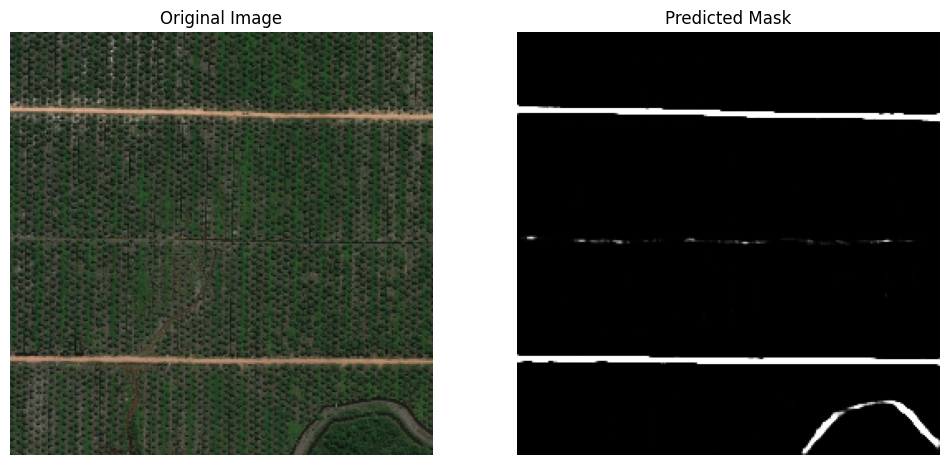

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load your trained model
model_path = "/kaggle/working/road_extraction_unet.h5"
model = tf.keras.models.load_model(model_path, compile=False)  # Load without compilation if necessary

def read_image(image_path, target_size=(256, 256)):  
    """ Reads and preprocesses the input image. """
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read in color mode
    if img is None:
        print(f"Error: Unable to read image at {image_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, target_size)  # Resize to match model input shape
    img = img / 255.0  # Normalize pixel values (0-1)
    return img

# Provide the image path directly
image_path = "/kaggle/input/deepglobe-road-extraction-dataset/train/100081_sat.jpg"  # Update with actual path

# Read and process the image
sample_img = read_image(image_path)

if sample_img is not None:
    sample_img_expanded = np.expand_dims(sample_img, axis=0)
    prediction = model.predict(sample_img_expanded)[0]

    plt.figure(figsize=(12, 6))
    
    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(sample_img)
    plt.title('Original Image')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 2, 2)
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()
else:
    print("Error: Image could not be loaded. Please check the file path.")


*Visualizing Loss*

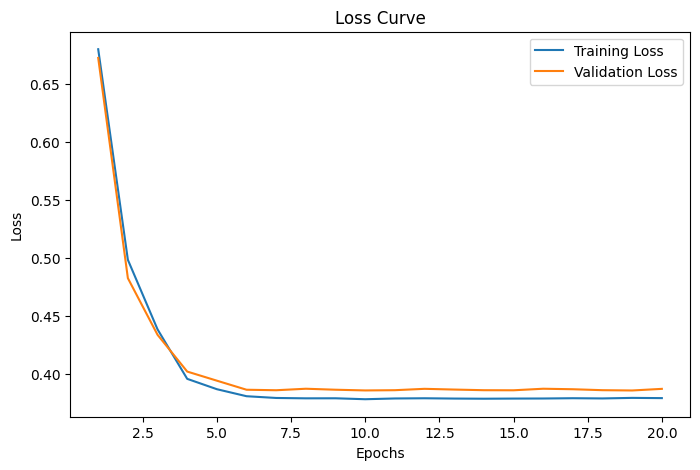

In [12]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Use the actual number of epochs that were run:
epochs_ran = len(training_loss)

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs_ran + 1), training_loss, label='Training Loss')
plt.plot(range(1, epochs_ran + 1), validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()
